# import libraries

In [1]:
import os
import skimage.io
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import zipfile
import json
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from skimage.transform import resize
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix ,ConfusionMatrixDisplay ,roc_curve, auc , accuracy_score , classification_report
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# helpful function

In [2]:
# display some images from the dataset

def draw_func(list_of_imgs, list_of_labels):
    # create figure
    fig = plt.figure(figsize=(10, 7))
    # setting values to rows and column variables
    rows, columns = 3, 3

    # Separate fake and real images based on labels
    fake_images = [img for img, label in zip(list_of_imgs, list_of_labels) if label == 'fake' or 'fake1' or 'fake2' or 'fake3' or 'fake4'or 'fake5'  ]
    real_images = [img for img, label in zip(list_of_imgs, list_of_labels) if label == 'real' or 'real1'or 'real2'or 'real3'or 'real4'or 'real5']

    # Randomly select fake and real images with appropriate sample sizes
    fake_sample_size = min(5, len(fake_images))  # Adjust sample size if fewer than 5 fake images
    real_sample_size = min(4, len(real_images))  # Adjust sample size if fewer than 4 real images
    fake_sample = random.sample(fake_images, fake_sample_size)
    real_sample = random.sample(real_images, real_sample_size)

    # Combine the selected images and labels
    sample_images = fake_sample + real_sample
    sample_labels = ['fake'] * fake_sample_size + ['real'] * real_sample_size

    # Iterate over the selected images and labels
    for i, (img, label) in enumerate(zip(sample_images, sample_labels)):
        # Adds a subplot at the i+1 position
        ax = fig.add_subplot(rows, columns, i+1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label)  # Set the title as the corresponding label

    plt.tight_layout()
    plt.show()

In [3]:
# Define a learning rate schedule
def lr_schedule(epoch):
    lr = 1e-4 * (0.95 ** epoch)  # Reduce the learning rate by 5% every epoch
    return lr

# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [4]:
# Plot learning curve
def plot_learning_curve(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.tight_layout()
    plt.show()

In [5]:
# function for evaluate the modl on test data
threshold = 0.5
def evaluate_test(model):
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(x_test , y_test, verbose=0)
    y_test_pred = model.predict(x_test)
    threshold = 0.5
    y_test_pred_binary = (y_test_pred > threshold).astype(int)


    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_accuracy)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
    # Generate a classification report
    report = classification_report(y_test, y_test_pred_binary)

    # Print the classification report
    print("\n")
    print("Classification Report:")
    print(report)
    return test_loss, test_accuracy

In [6]:
# function for predict confusion matrix
def prediction_confmatrix(model):
    # Get the predicted labels for training, validation, and test sets
    y_train_pred = model.predict(x_train)
    y_val_pred  = model.predict(x_val)
    y_test_pred = model.predict(x_test)

    threshold = 0.5
    y_train_pred_binary = (y_train_pred > threshold).astype(int)
    y_val_pred_binary = (y_val_pred > threshold).astype(int)
    y_test_pred_binary = (y_test_pred > threshold).astype(int)


    # Compute the confusion matrix for training, validation, and test sets
    train_conf_matrix = confusion_matrix(y_train,y_train_pred_binary)
    val_conf_matrix = confusion_matrix(y_val, y_val_pred_binary)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

        # Set up the plot with a blue color map
    fig, axes = plt.subplots(1, 3, figsize=(16, 6), dpi=100)

    # Plot the confusion matrix for training set
    sns.heatmap(train_conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"],
                ax=axes[0])
    axes[0].set(title='Confusion Matrix - Training Set')

    # Print the confusion matrix for training set
    print("Confusion Matrix - Training Set:")
    print(train_conf_matrix)

    # Plot the confusion matrix for validation set
    sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"],
                ax=axes[1])
    axes[1].set(title='Confusion Matrix - Validation Set')

    # Print the confusion matrix for validation set
    print("Confusion Matrix - Validation Set:")
    print(val_conf_matrix)

    # Plot the confusion matrix for test set
    sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"],
                ax=axes[2])
    axes[2].set(title='Confusion Matrix - Test Set')

    # Print the confusion matrix for test set
    print("Confusion Matrix - Test Set:")
    print(test_conf_matrix)

    plt.show()

    return y_train_pred_binary ,y_val_pred_binary, y_test_pred_binary ,train_conf_matrix,val_conf_matrix,test_conf_matrix

In [7]:
# Function to load images and resize them to (128, 128, 3)
def load_images(folder_path, limit=5000):
    images = []
    file_names = os.listdir(folder_path)

    # Ensure we don't exceed the limit
    for i, file_name in enumerate(file_names):
        if i >= limit:
            break
        file_path = os.path.join(folder_path, file_name)
        image = skimage.io.imread(file_path)
        image = resize(image, (128, 128, 3), anti_aliasing=True)
        images.append(image)

    return images

# load dataset

In [8]:
#define path and folders inside it
train_p ='E:\\New folder (6)\\New folder\\train'
test_p ='E:\\New folder (6)\\New folder\\test'
val_p = 'E:\\New folder (6)\\New folder\\valid'
folders = [f for f in os.listdir(train_p)]
print("folders=", folders)

folders= ['fake', 'real']


train data

In [9]:
#load the train data and put it in dataframe
train = pd.DataFrame(columns=['image', 'label'])

for folder in folders:
    images = load_images(os.path.join(train_p, folder))
    train_df = pd.DataFrame({'image': images ,'label': folder})
    train = pd.concat([train_df,train], ignore_index=False)
# Shuffle the data in the DataFrame
train = train.sample(frac=1).reset_index(drop=True)
train.head()

,image,label
0,"[[[0.051468347254317356, 0.0636536114395009, 0...",real
1,"[[[0.22398312676332569, 0.2909776423853362, 0....",real
2,"[[[0.9570976024814877, 0.9498857092292144, 0.9...",fake
3,"[[[0.24156427293189178, 0.19535186512795422, 0...",fake
4,"[[[0.5874882842343226, 0.5445713552783924, 0.5...",fake


In [10]:
train

,image,label
0,"[[[0.051468347254317356, 0.0636536114395009, 0...",real
1,"[[[0.22398312676332569, 0.2909776423853362, 0....",real
2,"[[[0.9570976024814877, 0.9498857092292144, 0.9...",fake
3,"[[[0.24156427293189178, 0.19535186512795422, 0...",fake
4,"[[[0.5874882842343226, 0.5445713552783924, 0.5...",fake
...,...,...
9995,"[[[0.09350827823452085, 0.2536433352711681, 0....",real
9996,"[[[0.7868739388260048, 0.7915773578413398, 0.7...",fake
9997,"[[[0.8333573190478283, 0.13055274839743483, 0....",real
9998,"[[[0.34574400471312067, 0.48725777530728054, 0...",real


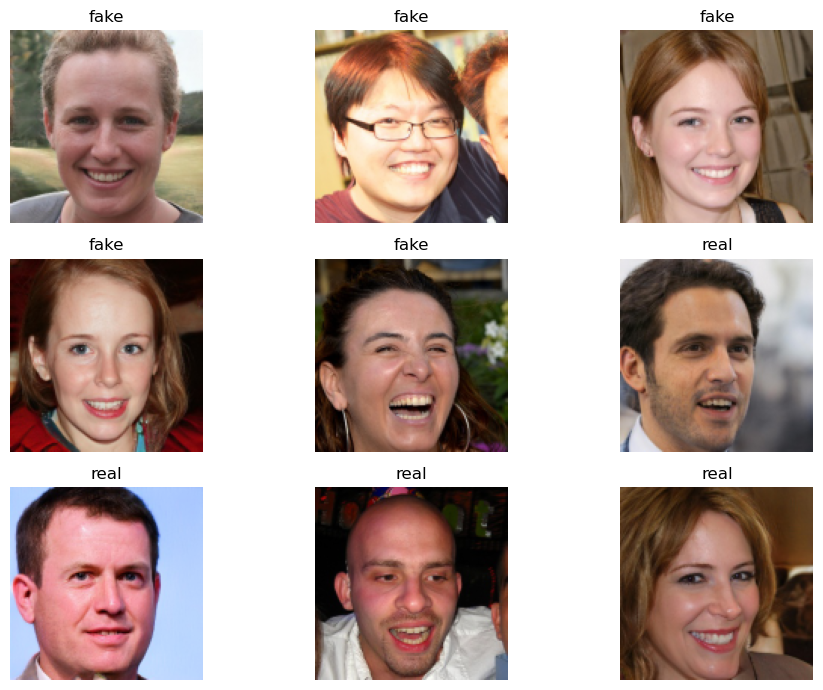

In [11]:
# show images sampels
draw_func(train['image'] ,train['label'])

test data

In [12]:
#load the test data and put it in dataframe
test = pd.DataFrame(columns=['image', 'label'])

for folder in folders:
    images = load_images(os.path.join(test_p, folder))
    test_df = pd.DataFrame({'image': images ,'label': folder})
    test = pd.concat([test_df,test], ignore_index=False)

# Shuffle the data in the DataFrame
test = test.sample(frac=1).reset_index(drop=True)
test


,image,label
0,"[[[0.6416933379761336, 0.6680001413351012, 0.5...",fake
1,"[[[0.7929734976317779, 0.7772872231219741, 0.7...",fake
2,"[[[0.6728876684871218, 0.7448053331216846, 0.7...",real
3,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",fake
4,"[[[0.6901960784313725, 0.7058823529411764, 0.6...",real
...,...,...
9995,"[[[0.5751400900907814, 0.5565820702564028, 0.5...",fake
9996,"[[[0.33646267391633533, 0.26195286999476664, 0...",fake
9997,"[[[0.6223867385567063, 0.40466776579792835, 0....",fake
9998,"[[[0.2728419982668635, 0.2728419982668635, 0.3...",real


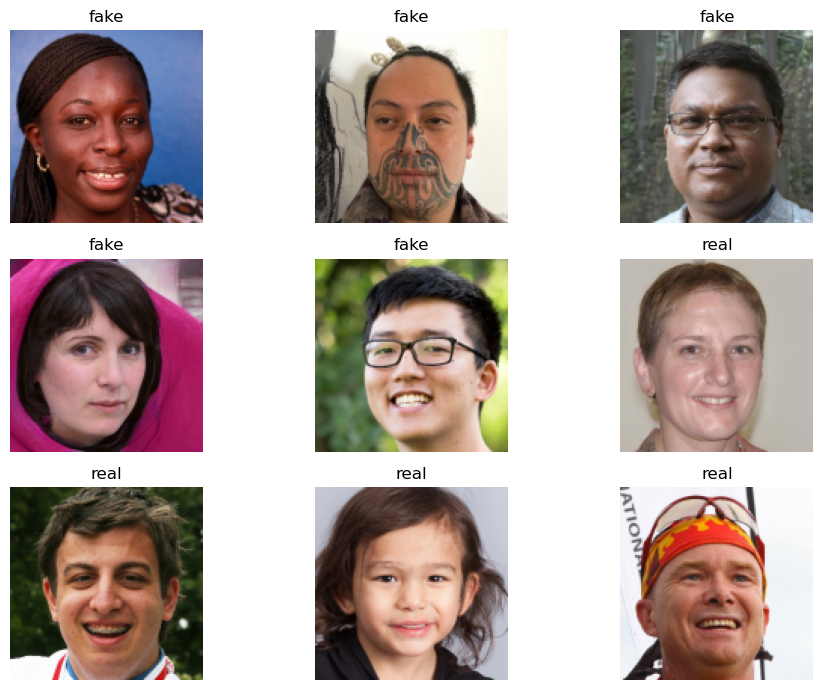

In [13]:
# show images sampels
draw_func(test['image'] ,test['label'])

validation data

In [14]:
#load the val data and put it in dataframe
val = pd.DataFrame(columns=['image', 'label'])

for folder in folders:
    images = load_images(os.path.join(val_p, folder))
    val_df = pd.DataFrame({'image': images ,'label': folder})
    val = pd.concat([val_df,val], ignore_index=False)

# Shuffle the data in the DataFrame
val = val.sample(frac=1).reset_index(drop=True)
val.head()

,image,label
0,"[[[0.9963817710710274, 0.9975250242415782, 0.9...",real
1,"[[[0.5878117423538576, 0.5564391933342497, 0.5...",fake
2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",real
3,"[[[0.7798453190831834, 0.7284668639038799, 0.6...",fake
4,"[[[0.10958046437831949, 0.12526673888812342, 0...",fake


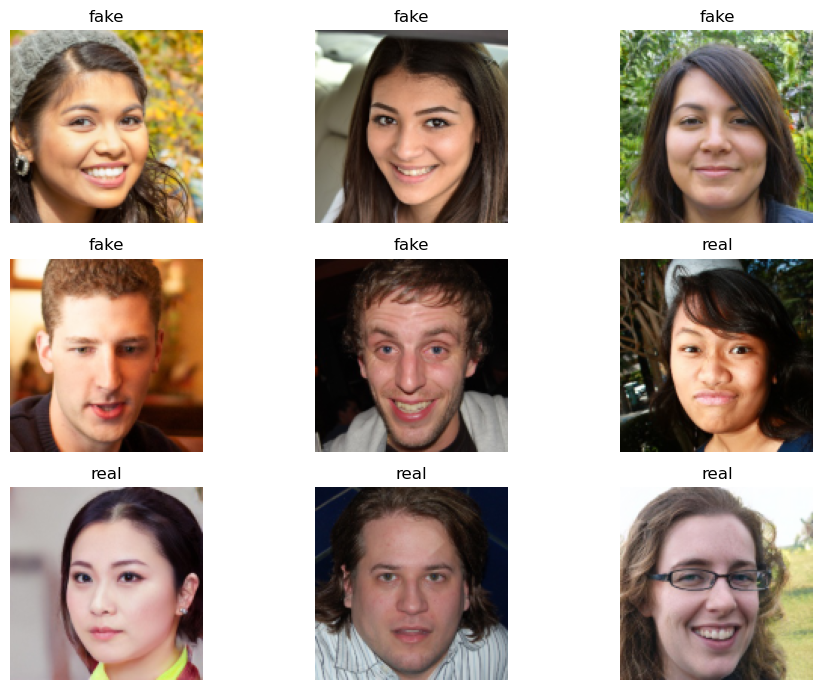

In [15]:
# show images sampels
draw_func(val['image'] ,val['label'])

# preprocess the data

In [16]:
#specify x for (train,val,test) then convert them to np.array to match the model
x_train = train['image']
x_val = val['image']
x_test = test['image']

x_train = np.stack(x_train.values)
x_val = np.stack(x_val.values)
x_test = np.stack(x_test.values)

In [17]:
x_train.shape , x_val.shape  , x_test.shape

((10000, 128, 128, 3), (10000, 128, 128, 3), (10000, 128, 128, 3))

In [18]:
#specify y for (train,val,test) then convert them to categorical to match the model
y_train = train['label']
y_val = val['label']
y_test = test['label']

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train= label_encoder.transform(y_train)

label_encoder.fit(y_val)
y_val= label_encoder.transform(y_val)

label_encoder.fit(y_test)
y_test= label_encoder.transform(y_test)

In [19]:
y_train.shape , y_val.shape  , y_test.shape

((10000,), (10000,), (10000,))

# models

In [20]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
# Define early stopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

***ResNet50***

In [21]:
# Load the ResNet50 model without the top (classification) layers
base_model1 = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom top layers for classification
model1 = Sequential()
model1.add(base_model1)
model1.add(GlobalAveragePooling2D())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24,112,513
Trainable params: 24,059,393
Non-trainable params: 53,120
_________________________________________________________________


In [22]:
# Compile the model
model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
history1 = model1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=16, callbacks=[early_stopping])

Epoch 1/20
625/625 [==============================] - 1216s 2s/step - loss: 0.3996 - accuracy: 0.8183 - val_loss: 0.7616 - val_accuracy: 0.5338
Epoch 2/20
625/625 [==============================] - 1126s 2s/step - loss: 0.1572 - accuracy: 0.9389 - val_loss: 0.2678 - val_accuracy: 0.8882
Epoch 3/20
625/625 [==============================] - 1128s 2s/step - loss: 0.0920 - accuracy: 0.9665 - val_loss: 0.2647 - val_accuracy: 0.8900
Epoch 4/20
625/625 [==============================] - 1081s 2s/step - loss: 0.0602 - accuracy: 0.9772 - val_loss: 0.1739 - val_accuracy: 0.9389
Epoch 5/20
625/625 [==============================] - 943s 2s/step - loss: 0.0435 - accuracy: 0.9843 - val_loss: 0.2168 - val_accuracy: 0.9223
Epoch 6/20
625/625 [==============================] - 967s 2s/step - loss: 0.0395 - accuracy: 0.9859 - val_loss: 0.3340 - val_accuracy: 0.9024
Epoch 7/20
625/625 [==============================] - 966s 2s/step - loss: 0.0316 - accuracy: 0.9895 - val_loss: 0.3060 - val_accuracy: 0.

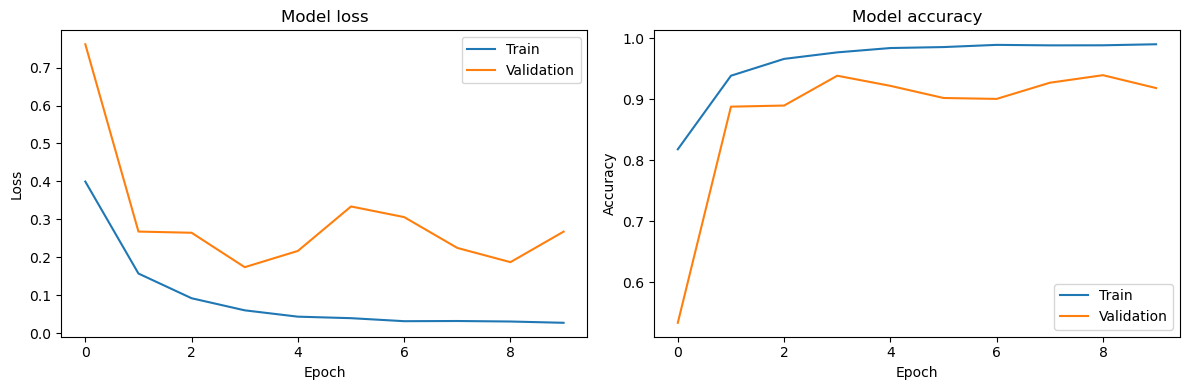

In [23]:
# Plot the learning curve
plot_learning_curve(history1)

In [24]:
# evaluate the model in test data
evaluation1=evaluate_test(model1)

313/313 [==============================] - 155s 476ms/step
Test Loss: 0.1755523383617401
Test Accuracy: 0.9376999735832214
Test Accuracy: 93.77%


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      5000
           1       0.94      0.93      0.94      5000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



313/313 [==============================] - 110s 351ms/step
Confusion Matrix - Training Set:
[[4976   24]
 [  31 4969]]
Confusion Matrix - Validation Set:
[[4713  287]
 [ 324 4676]]
Confusion Matrix - Test Set:
[[4707  293]
 [ 330 4670]]


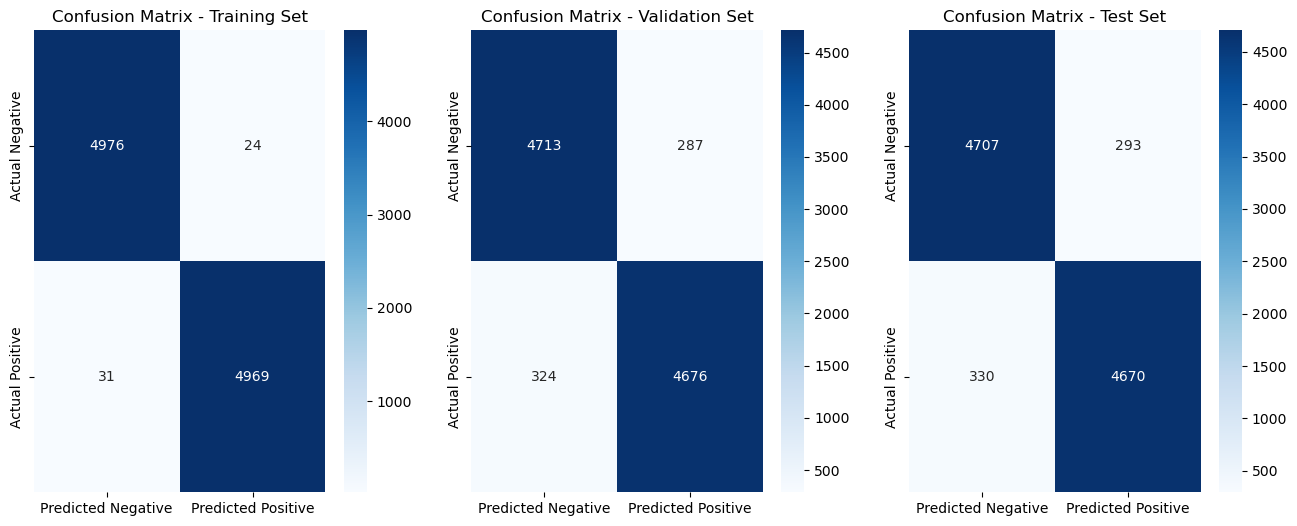

In [39]:
# predict values and confusion matrix
prediction1=prediction_confmatrix(model1)

 **Hyperprameter section for** **ResNet50**

increase batch size ,with constante learning rate 1e-4

In [40]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
# Define early stopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [41]:
# Load the ResNet50 model without the top (classification) layers
base_model2 = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


# Add custom top layers for classification
model2 = Sequential()
model2.add(base_model2)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24,112,513
Trainable params: 24,059,393
Non-trainable params: 53,120
_________________________________________________________________


In [42]:

# Compile the model
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32, callbacks=[early_stopping])

Epoch 1/20
313/313 [==============================] - 813s 3s/step - loss: 0.3880 - accuracy: 0.8228 - val_loss: 0.8681 - val_accuracy: 0.5000
Epoch 2/20
313/313 [==============================] - 778s 2s/step - loss: 0.1077 - accuracy: 0.9600 - val_loss: 0.7892 - val_accuracy: 0.5211
Epoch 3/20
313/313 [==============================] - 780s 2s/step - loss: 0.0561 - accuracy: 0.9807 - val_loss: 0.4984 - val_accuracy: 0.8337
Epoch 4/20
313/313 [==============================] - 779s 2s/step - loss: 0.0388 - accuracy: 0.9861 - val_loss: 0.4783 - val_accuracy: 0.8614
Epoch 5/20
313/313 [==============================] - 781s 2s/step - loss: 0.0373 - accuracy: 0.9864 - val_loss: 0.3478 - val_accuracy: 0.9095
Epoch 6/20
313/313 [==============================] - 782s 3s/step - loss: 0.0345 - accuracy: 0.9880 - val_loss: 0.2115 - val_accuracy: 0.9336
Epoch 7/20
313/313 [==============================] - 778s 2s/step - loss: 0.0268 - accuracy: 0.9910 - val_loss: 0.3344 - val_accuracy: 0.8986

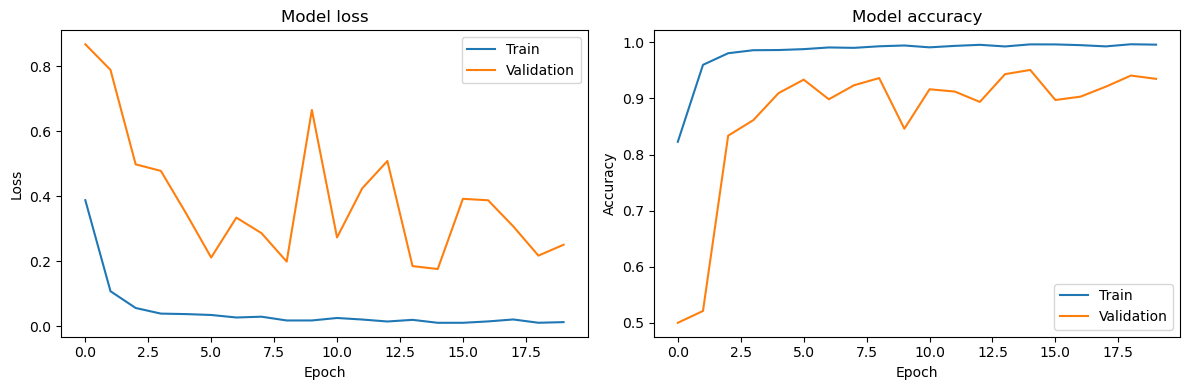

In [43]:
# Plot the learning curve
plot_learning_curve(history2)

In [44]:
# evaluate the model in test data
evaluation2=evaluate_test(model2)

313/313 [==============================] - 110s 345ms/step
Test Loss: 0.2523461580276489
Test Accuracy: 0.9330000281333923
Test Accuracy: 93.30%


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      5000
           1       0.96      0.91      0.93      5000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



313/313 [==============================] - 109s 348ms/step
Confusion Matrix - Training Set:
[[4995    5]
 [  39 4961]]
Confusion Matrix - Validation Set:
[[4792  208]
 [ 442 4558]]
Confusion Matrix - Test Set:
[[4789  211]
 [ 459 4541]]


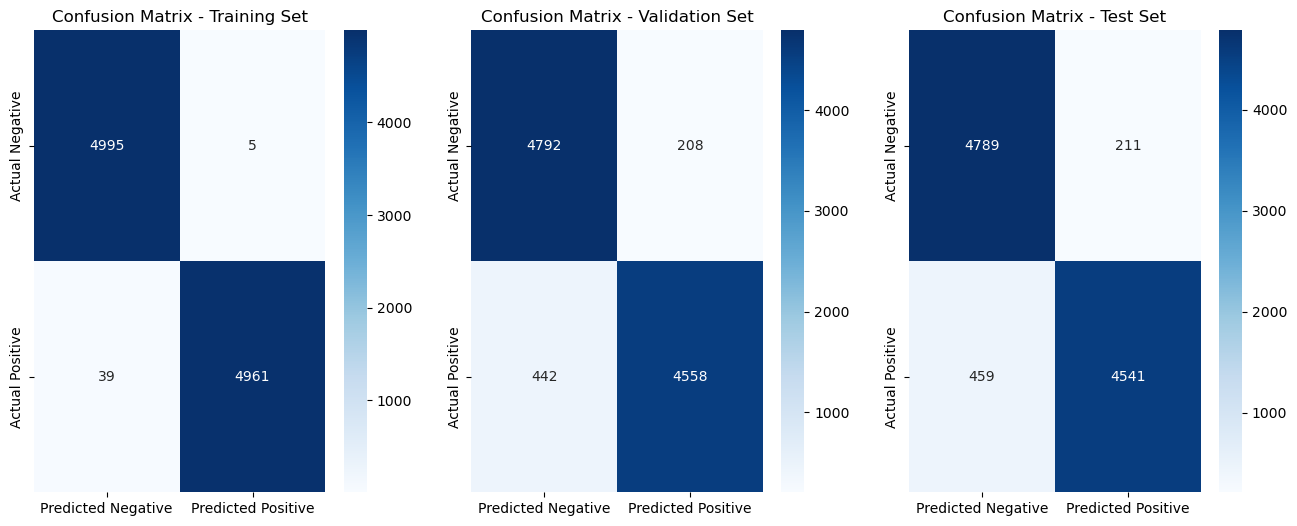

In [45]:
# predict values and confusion matrix
prediction2=prediction_confmatrix(model2)

decrease batch size ,with constante learning rate 1e-4

In [46]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
# Define early stopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [47]:
# Load the ResNet50 model without the top (classification) layers
base_model3 = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


# Add custom top layers for classification
model3 = Sequential()
model3.add(base_model3)
model3.add(GlobalAveragePooling2D())
model3.add(Dense(256, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
model3.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24,112,513
Trainable params: 24,059,393
Non-trainable params: 53,120
_________________________________________________________________


In [48]:

# Compile the model
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history3 = model3.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=8, callbacks=[early_stopping])


Epoch 1/20
1250/1250 [==============================] - 1348s 1s/step - loss: 0.4394 - accuracy: 0.7980 - val_loss: 0.3507 - val_accuracy: 0.8457
Epoch 2/20
1250/1250 [==============================] - 1234s 987ms/step - loss: 0.1984 - accuracy: 0.9250 - val_loss: 0.2489 - val_accuracy: 0.8991
Epoch 3/20
1250/1250 [==============================] - 1242s 994ms/step - loss: 0.1117 - accuracy: 0.9591 - val_loss: 0.2203 - val_accuracy: 0.9158
Epoch 4/20
1250/1250 [==============================] - 1287s 1s/step - loss: 0.0811 - accuracy: 0.9700 - val_loss: 0.4926 - val_accuracy: 0.8426
Epoch 5/20
1250/1250 [==============================] - 1252s 1s/step - loss: 0.0538 - accuracy: 0.9816 - val_loss: 0.2452 - val_accuracy: 0.9136
Epoch 6/20
1250/1250 [==============================] - 1235s 988ms/step - loss: 0.0519 - accuracy: 0.9816 - val_loss: 0.5963 - val_accuracy: 0.8389
Epoch 7/20
1250/1250 [==============================] - 1234s 987ms/step - loss: 0.0508 - accuracy: 0.9830 - val_lo

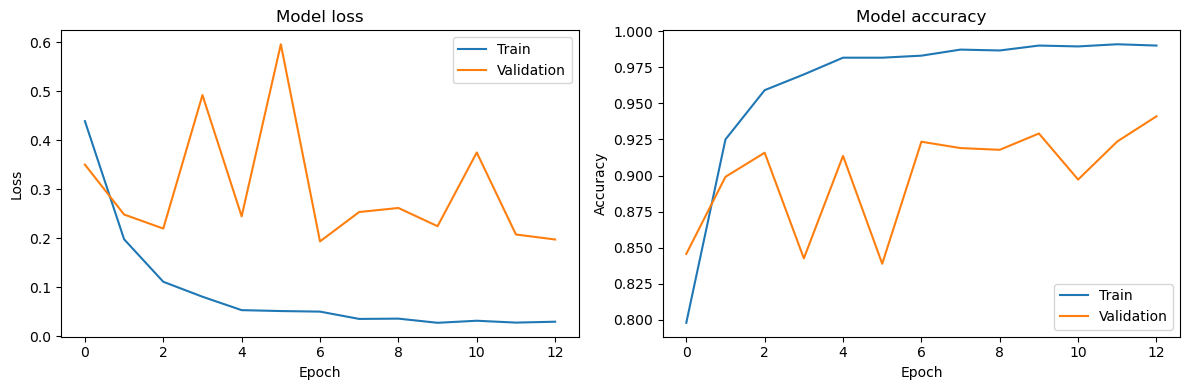

In [49]:
# Plot the learning curve
plot_learning_curve(history3)

In [50]:
# evaluate the model in test data
evaluation3=evaluate_test(model3)

313/313 [==============================] - 127s 402ms/step
Test Loss: 0.191042959690094
Test Accuracy: 0.9254000186920166
Test Accuracy: 92.54%


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93      5000
           1       0.95      0.90      0.92      5000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



313/313 [==============================] - 129s 414ms/step
Confusion Matrix - Training Set:
[[4978   22]
 [ 107 4893]]
Confusion Matrix - Validation Set:
[[4770  230]
 [ 536 4464]]
Confusion Matrix - Test Set:
[[4774  226]
 [ 520 4480]]


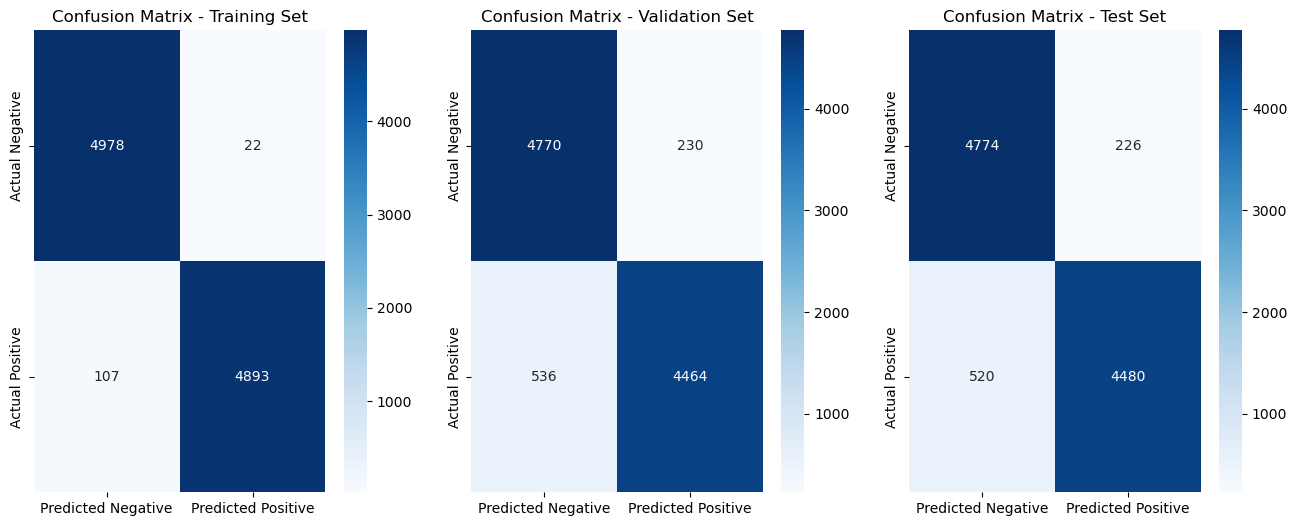

In [51]:
# predict values and confusion matrix
prediction3=prediction_confmatrix(model3)

comparison

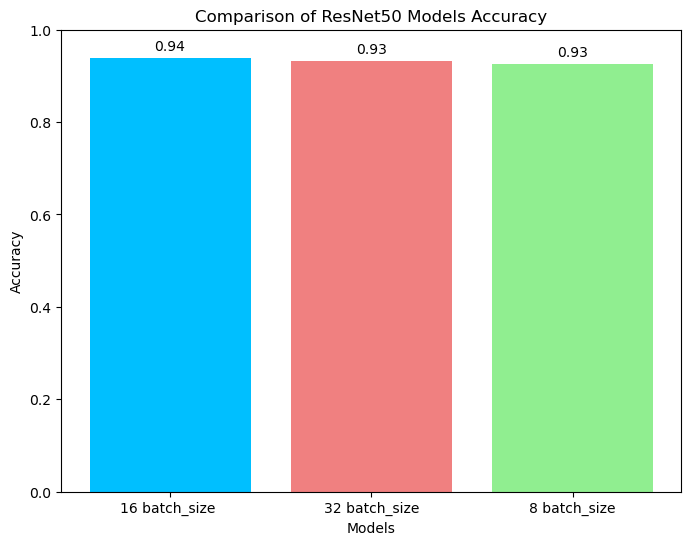

In [52]:

# Sample data for three models
models = ['16 batch_size ', '32 batch_size', '8 batch_size']
accuracy = [evaluation1[1],evaluation2[1],evaluation3[1]]

# Bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, accuracy, color=['deepskyblue','lightcoral', 'lightgreen' ])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of ResNet50 Models Accuracy')
plt.ylim(0, 1)  # Set y-axis range if needed

# Display the values on top of the bars
for i, value in enumerate(accuracy):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

# Show the plot
plt.show()


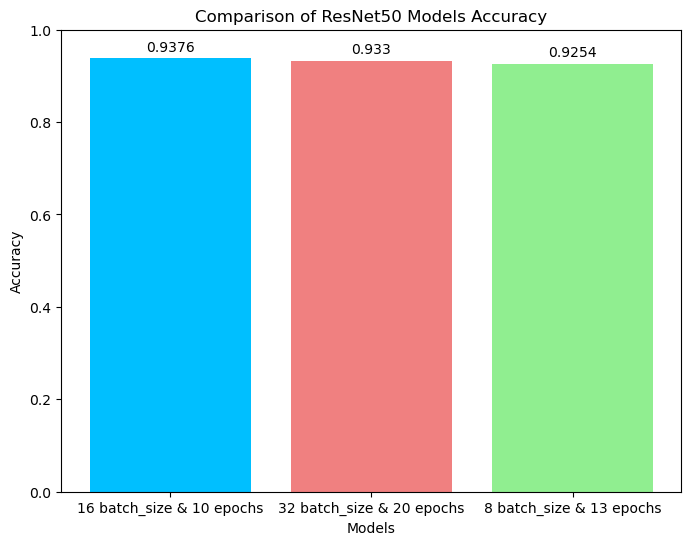

In [56]:

# Sample data for three models
models = ['16 batch_size & 10 epochs', '32 batch_size & 20 epochs', '8 batch_size & 13 epochs']
accuracy = [0.9376,0.9330, 0.925400]

# Bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracy, color=['deepskyblue','lightcoral', 'lightgreen'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of ResNet50 Models Accuracy')
plt.ylim(0, 1)  # Set y-axis range if needed

# Display the values on top of the bars without rounding
for bar, value in zip(bars, accuracy):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 0.01, f'{value}', ha='center', va='bottom')

# Show the plot
plt.show()